In [1]:
import data_processing
import numpy as np
import matplotlib.pyplot as plt
import yaml
import os

In [2]:
def get_config(key) -> int:
    with open('./conf/config.yaml') as file:
        file = yaml.load(file, Loader=yaml.FullLoader)

    return file[key]

In [3]:
config = get_config('CONFIG')
paths = get_config('PATHS')
print(config)

{'IMG_SHAPE': [105, 105, 1], 'BATCH_SIZE': 63, 'EPOCHS': 100, 'LEARNING_RATE': 0.01, 'VALIDATION_SPLIT': 0.2}


In [4]:
X, y = data_processing.load_images(paths['BASE_PATH']+'train')
print(X.shape)
print(y.shape)

(38, 105, 105)
(38,)


In [5]:
(X_train, y_train) = data_processing.make_pairs(X, y)

In [6]:
print(X_train.shape)
print(y_train.shape)

(596, 2, 105, 105)
(596, 1)


In [9]:
# WATCH OUT !!! - this can print way too many images :)
# 0 - for negatives
# 1 - for positives 
# data_processing.show_positive_train(X_train, y_train, 0)

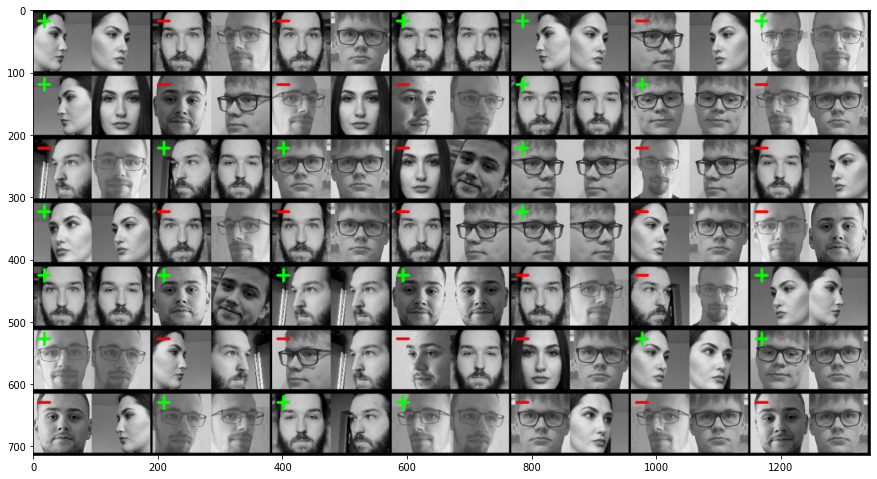

In [10]:
data_processing.pairs_montage(X_train, y_train)

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, Dense, Lambda, Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Convolution2D, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.regularizers import l2
import tensorflow_addons as tfa

In [12]:
def initialize_weights(shape, dtype=None):
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

In [13]:
def initialize_bias(shape, dtype=None):
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

In [14]:
def build_siamese_model(input_shape):

    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    kernel_size = 3
    # CNN
    model = Sequential()
    # input layer
    model.add(Conv2D(32, (5,5), activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling2D())
    model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid'))

    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)

    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])

    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1, activation='sigmoid')(L1_distance)

    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input, right_input], outputs=prediction)

    # return the model
    return siamese_net

In [15]:
model = build_siamese_model(config['IMG_SHAPE'])
model.summary()

2022-04-09 09:05:33.251840: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 105, 105, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 105, 105, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 4096)         38288768    ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

In [16]:
optimizer = Adam(learning_rate=config['LEARNING_RATE'])
model.compile(loss=tfa.losses.ContrastiveLoss(), optimizer=optimizer)

In [17]:
trainX = np.expand_dims(X, axis=-1)
(X_train, y_train) = data_processing.make_pairs(trainX, y)

In [18]:
history = model.fit(
	[X_train[:, 0], X_train[:, 1]], y_train[:],
	validation_split=config['VALIDATION_SPLIT'],
	batch_size=config['BATCH_SIZE'], 
	epochs=config['EPOCHS'],
	verbose=True)

Epoch 1/100
8/8 [==============================] - 17s 2s/step - loss: 0.2504 - val_loss: 0.2489
Epoch 2/100
8/8 [==============================] - 13s 2s/step - loss: 0.2476 - val_loss: 0.2479
Epoch 3/100
8/8 [==============================] - 13s 2s/step - loss: 0.2423 - val_loss: 0.2491
Epoch 4/100
8/8 [==============================] - 16s 2s/step - loss: 0.2388 - val_loss: 0.2529
Epoch 5/100
4/8 [==============>...............] - ETA: 6s - loss: 0.2404

KeyboardInterrupt: 

In [ ]:
model.save(paths['MODEL_PATH'])

In [ ]:
plt.figure(figsize=(15,8))

plt.xlabel('Epoch')
plt.ylabel('MSE')

plt.plot(model.history.history['loss'][:], label='loss')
plt.plot(model.history.history['val_loss'][:], label='val_Loss')
plt.legend()

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
for filename in os.scandir(paths['BASE_PATH']+paths['TEST_SAMPLES']):
    if filename.is_file() and '.DS_Store' not in filename.path:
        sample_name = filename.path
        data_processing.evaluate_data(model, paths['BASE_PATH']+paths['TEST_CLASSES'], sample_name,)